In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
import settings
import utils

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from xgboost import XGBClassifier
import xgboost as xgb

In [5]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [6]:
plt.rc('text', usetex=True)
plt.rc('font', size=14)
plt.rc('legend', fontsize=13)

## Get generated data

In [7]:
filter_names, colors = pickle.load(open("output/colors_f1.pkl", "rb"))

In [8]:
filter_info = pickle.load(open("output/filters_f1.pkl", "rb"))

In [9]:
# load all component combinations that sum to unity
component_names, unity_surface_combinations = pickle.load(open("output/surface_combinations.pkl", "rb"))

In [10]:
unity_surface_combinations_df = pd.DataFrame(unity_surface_combinations, 
                                             columns=component_names)
unity_surface_combinations_df

,cloud,snow,sand,seawater,basalt,veg
0,0.00,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,0.00,0.00,0.05,0.95
2,0.00,0.00,0.00,0.00,0.10,0.90
3,0.00,0.00,0.00,0.00,0.15,0.85
4,0.00,0.00,0.00,0.00,0.20,0.80
...,...,...,...,...,...,...
53125,0.95,0.00,0.00,0.00,0.05,0.00
53126,0.95,0.00,0.00,0.05,0.00,0.00
53127,0.95,0.00,0.05,0.00,0.00,0.00
53128,0.95,0.05,0.00,0.00,0.00,0.00


In [11]:
# colors_and_combinations = np.concatenate((unity_surface_combinations, colors), axis=1)
# main_df = pd.DataFrame(colors_and_combinations,
#                        columns=component_names + filter_names)

## Analyze data

In [12]:
model, feature_importance = pickle.load(open(f"output/models_and_features.pkl", "rb"))

In [13]:
# use top 5 filters
N_GOOD_FILTERS = 5

good_filters = np.sort(feature_importance.flatten())[-N_GOOD_FILTERS:]
good_filters_idx = np.argwhere(np.isin(feature_importance, good_filters))[:,1]
good_filters_values = np.array(list(filter_info.values()))[good_filters_idx]
good_filters_name = np.array(list(filter_info.keys()))[good_filters_idx]
good_filters_info = {name: val for name, val in zip(good_filters_name, good_filters_values) }

# # save good filters info
# pickle.dump(good_filters_info ,open("output/good_filters_info.pkl", "wb"))

In [14]:
nice_filter_names = []
for i, _ in enumerate(filter_names):
    if i in good_filters_idx:
        nice_filter_names.append(r"$\underline{{f}_" + str(i+1) + "}$")
    else:
        nice_filter_names.append(r"$f_" + str(i+1) + "$")

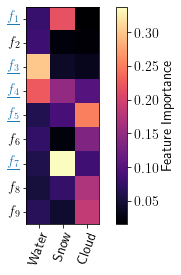

In [15]:
fig, ax = plt.subplots()
img = ax.imshow(feature_importance.T, cmap='magma')

fig.colorbar(img, label='Feature Importance')

nice_component_names = ['Water', 'Snow', 'Cloud']

ax.set_xticks(np.arange(0, len(settings.CLASSIFYING_COMPONENTS), 1))
ax.set_xticklabels(nice_component_names, rotation=70)

ax.set_yticks(np.arange(0, len(filter_names), 1))
ax.set_yticklabels(nice_filter_names);

for idx in good_filters_idx:
    ax.get_yticklabels()[idx].set_color("tab:blue")
    ax.get_yticklabels()[idx].set_weight("bold")
    ax.get_yticklabels()[idx].set_style("italic")
    

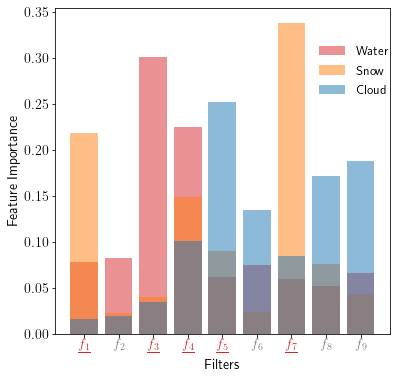

In [16]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(6,6))

for i in range(feature_importance.shape[0]):
    
    ax.bar(nice_filter_names, feature_importance[i,:], 
           color=settings.color_list[i], label=nice_component_names[i],
           alpha=0.5)
    ax.set_ylabel('Feature Importance')

    
for i, xticklabel in enumerate(ax.get_xticklabels()):
    if i in good_filters_idx:
        xticklabel.set_color("tab:red")
    else:
        xticklabel.set_color("tab:gray")

# ax.axhline(min(good_filters)-0.01, linestyle='--', color='k')
# fig.subplots_adjust( hspace=0 )
ax.set_xlabel('Filters')
fig.legend(frameon=False, bbox_to_anchor=(0.925,0.8));

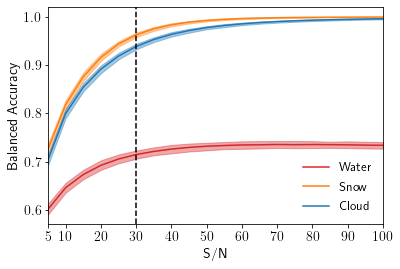

In [22]:
fig, ax = plt.subplots()
for i, component in enumerate(settings.CLASSIFYING_COMPONENTS):
    _, _, snrs, _, _, ba_score_no_noise, ba_scores = pickle.load(open(f"output/result_{component}.pkl", "rb"))
    lower, median, upper = np.percentile(ba_scores, (2.5, 50, 97.5), axis=1)
    plotline, = ax.plot(snrs, median, label=nice_component_names[i], c=settings.color_list[i])
    
    # ax.axhline(ba_score_no_noise, color=plotline.get_color(), linestyle='--', alpha=0.5)
    ax.fill_between(snrs, lower, upper, alpha=0.4, color=settings.color_list[i])

ax.axvline(30, c='k', linestyle='--')
ax.set_xlim([5, 100])
ax.set_xticks([5] + list(np.arange(10, 110, 10)))
ax.legend(frameon=False)
ax.set_xlabel('S/N')
ax.set_ylabel('Balanced Accuracy');

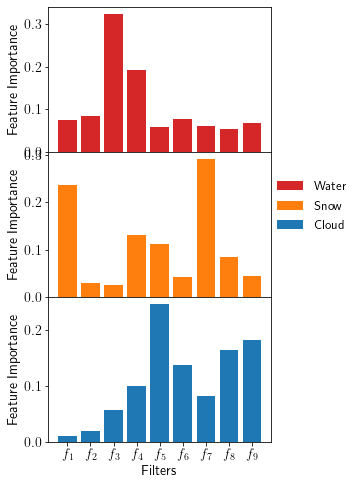

In [101]:
fig, axes = plt.subplots(nrows=feature_importance.shape[0], sharex=True, figsize=(4,8))
color_list = ['tab:red', 'tab:orange', 'tab:blue']
for i, ax in enumerate(axes):
    ax.bar(nice_filter_names, feature_importance[i,:], color=color_list[i], label=nice_component_names[i])
    ax.set_ylabel('Feature Importance')
fig.subplots_adjust( hspace=0 )
axes[2].set_xlabel('Filters')
fig.legend(frameon=False, bbox_to_anchor=(1.2, 0.6));